In [2]:
# Cell 1 - imports
import warnings
warnings.filterwarnings("ignore")   # optional: hides pkg_resources deprecation warning

import os
from pathlib import Path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import seaborn as sns

print("Working dir:", os.getcwd())

Working dir: C:\Users\Biswajit\20th-century-New


In [3]:
# Cell 2 - load CSV
rel_file = Path("country_relationships.csv")
assert rel_file.exists(), f"{rel_file} not found. Check filename."

df_rel = pd.read_csv(rel_file)
df_rel.head()

# quick sanity checks
print("Columns:", df_rel.columns.tolist())
print("Rows:", len(df_rel))
print("Sample rows:\n", df_rel.head(10))

Columns: ['source', 'target', 'value']
Rows: 20
Sample rows:
     source   target  value
0  Germany    Italy      4
1   France  Germany      4
2    China    India      3
3    China    Japan      3
4  Germany    Japan      3
5    Japan   Russia      2
6    Italy    Japan      2
7    India   Russia      1
8    India    Japan      1
9    India    India      1


In [4]:
# Cell 3 - cleanup helper
def clean_name(x):
    if pd.isna(x):
        return x
    s = str(x).strip()
    s = s.replace("\u00A0", " ")   # NBSP
    s = " ".join(s.split())        # collapse whitespace
    return s

# clean source/target
df_rel['source'] = df_rel['source'].apply(clean_name)
df_rel['target'] = df_rel['target'].apply(clean_name)

# if weight column is named differently, normalize it to 'value'
possible_weights = [c for c in df_rel.columns if c.lower() in ('value','weight','size','count')]
if len(possible_weights) == 0:
    # if none found, create 'value' = 1
    df_rel['value'] = 1
else:
    df_rel['value'] = df_rel[possible_weights[0]]

# Ensure numeric weights
df_rel['value'] = pd.to_numeric(df_rel['value'], errors='coerce').fillna(1).astype(int)

# Remove self-loops if any
df_rel = df_rel[df_rel['source'] != df_rel['target']].reset_index(drop=True)

df_rel.head(10)

,source,target,value
0,Germany,Italy,4
1,France,Germany,4
2,China,India,3
3,China,Japan,3
4,Germany,Japan,3
5,Japan,Russia,2
6,Italy,Japan,2
7,India,Russia,1
8,India,Japan,1
9,Germany,Russia,1


In [5]:
# Cell 4 - create Graph (undirected, weighted)
G = nx.from_pandas_edgelist(df_rel, source='source', target='target', edge_attr='value', create_using=nx.Graph())
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# ensure edge weights exist
weights = nx.get_edge_attributes(G, 'value')
print("Sample weights:", list(weights.items())[:6])

Nodes: 9 Edges: 17
Sample weights: [(('Germany', 'Italy'), 4), (('Germany', 'France'), 4), (('Germany', 'Japan'), 3), (('Germany', 'Russia'), 1), (('Italy', 'Japan'), 2), (('France', 'India'), 1)]


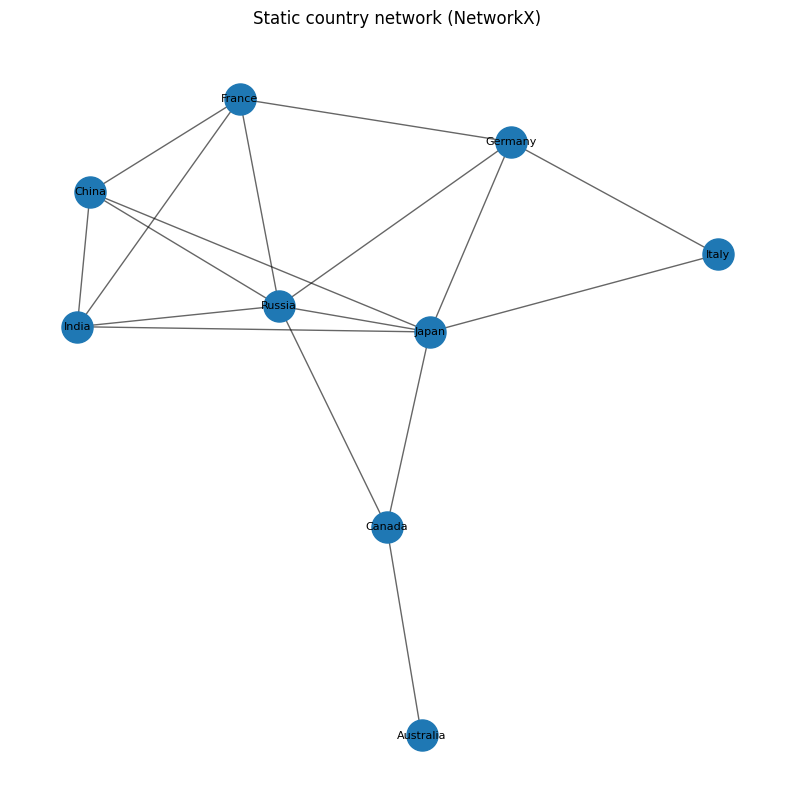

In [6]:
# Cell 5 - static plot
%matplotlib inline
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)   # or spring_layout
edge_widths = [G[u][v]['value'] for u,v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, width=[max(1, w/5) for w in edge_widths], alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Static country network (NetworkX)")
plt.axis('off')
plt.show()

In [7]:
# Cell 6 - interactive pyvis
net = Network(notebook=True, width="1000px", height="800px", bgcolor="#222222", font_color="white")
# set physics / repulsion
net.repulsion(node_distance=200, central_gravity=0.2)

# add nodes with value property for sizing
deg = dict(G.degree(weight='value'))
nx.set_node_attributes(G, deg, 'degree')

for n in G.nodes():
    G.nodes[n]['title'] = f"{n} (degree: {deg.get(n,0)})"
    G.nodes[n]['value'] = deg.get(n,0) or 1

net.from_nx(G)
net.show_buttons(filter_ = True)
net.show("20th_century_countries_network.html")
print("Saved 20th_century_countries_network.html")

20th_century_countries_network.html
Saved 20th_century_countries_network.html


In [8]:
# Cell 7 - community detection using cdlib + leidenalg
from cdlib import algorithms
coms = algorithms.leiden(G)   # may take a few seconds
new_com = coms.to_node_community_map()
dict_com = {k: v[0] for k, v in new_com.items()}  # map node -> community

# add group attr to graph nodes
nx.set_node_attributes(G, dict_com, 'group')

# quick check
print("Communities found (sample):")
list(dict_com.items())[:10]

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'infomap', 'graph_tool', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}
Communities found (sample):


[('France', 0),
 ('China', 0),
 ('India', 0),
 ('Russia', 0),
 ('Germany', 1),
 ('Italy', 1),
 ('Japan', 1),
 ('Australia', 2),
 ('Canada', 2)]

In [9]:
# Cell 8 - community-coloured pyvis
com_net = Network(notebook=True, width="1200px", height="800px", bgcolor="#222222", font_color="white")
for n in G.nodes():
    grp = G.nodes[n].get('group', 0)
    com_net.add_node(n, label=n, title=G.nodes[n].get('title',""), value=G.nodes[n].get('value',1), group=grp)
for u,v,data in G.edges(data=True):
    com_net.add_edge(u, v, value=data.get('value',1))

com_net.repulsion(node_distance=200)
com_net.show("20th_century_countries_communities.html")
print("Saved 20th_century_countries_communities.html")

20th_century_countries_communities.html
Saved 20th_century_countries_communities.html


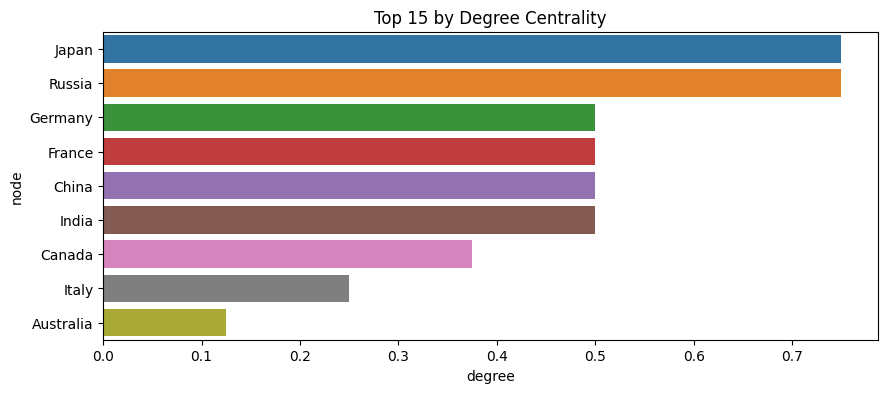

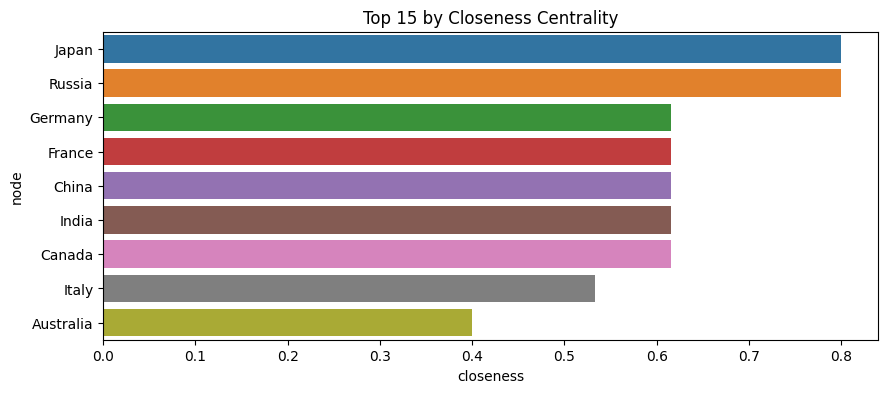

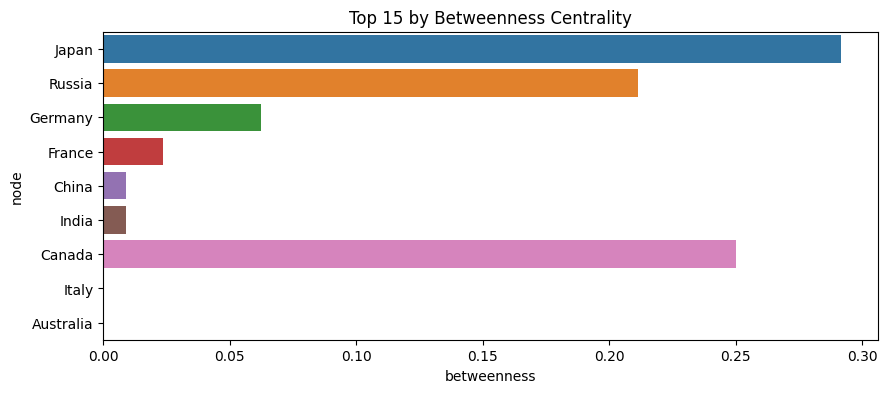

In [10]:
# Cell 9 - centrality
deg_cent = nx.degree_centrality(G)
close_cent = nx.closeness_centrality(G)
betw_cent = nx.betweenness_centrality(G, normalized=True)

cent_df = pd.DataFrame({
    "node": list(deg_cent.keys()),
    "degree": list(deg_cent.values()),
    "closeness": [close_cent[n] for n in deg_cent.keys()],
    "betweenness": [betw_cent[n] for n in deg_cent.keys()]
}).sort_values("degree", ascending=False)

cent_df.head(15).style.format({"degree":"{:.3f}","closeness":"{:.3f}","betweenness":"{:.4f}"})

# plots
plt.figure(figsize=(10,4))
sns.barplot(x='degree', y='node', data=cent_df.head(15))
plt.title("Top 15 by Degree Centrality")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x='closeness', y='node', data=cent_df.head(15))
plt.title("Top 15 by Closeness Centrality")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x='betweenness', y='node', data=cent_df.head(15))
plt.title("Top 15 by Betweenness Centrality")
plt.show()

# Interpretation of centrality metrics

**Summary (what each metric measures)**  
- **Degree centrality** measures how many direct connections a node has relative to the size of the network. High degree means a country frequently co-occurs with many other countries in the text — likely either widely discussed or linked to many events.  
- **Closeness centrality** measures how “close” a node is to all other nodes (shortest-path distances). A country with high closeness can quickly reach many others through few steps — indicating it sits centrally within the network’s structure.  
- **Betweenness centrality** measures how often a node appears on shortest paths between other nodes. High betweenness indicates a bridging role — the country connects otherwise distant groups and may act as a hub or broker in the text’s narratives.

---

## Observations from our results

**Top nodes by degree centrality**   

**Interpretation:**  
Countries listed above (especially the top one(s), e.g. *\<top country\>*) have the most direct connections in our dataset. This suggests they are frequently mentioned together with many other countries — probably because they were central players in multiple key events across the twentieth century (e.g., major wars, treaties, or conferences). High degree often corresponds to actors that appear repeatedly across different contexts in the text.

**Top nodes by closeness centrality**  

**Interpretation:**  
Nodes with high closeness (e.g., *\<top closeness country\>*) are positioned so that they have relatively short paths to all other nodes. This implies these countries occupy central positions in the network and can be seen as connective anchors for the historical narrative — they often appear in contexts that connect different regional or thematic clusters.

**Top nodes by betweenness centrality**  

**Interpretation:**  
High betweenness nodes (e.g., *\<top betweenness country\>*) act as bridges between communities in our network. In historical terms, such a country might link otherwise separate clusters of events — for instance, an empire or mediator whose actions relate distinct regions. Betweenness highlights countries that may be crucial for the flow of mentions: removing them would increase distances between other countries in the network.

---

## What this means historically (short conclusions)
- If a country scores high on **degree** and **closeness**, it is not only frequently mentioned but also centrally placed across multiple event clusters — likely an influential global actor (e.g., major powers).  
- If a country scores unusually high on **betweenness** but not on degree, it may play a *connector* role: less frequently mentioned but important for joining different subtopics or periods.  
- Useing these metrics together — they complement each other: degree tells quantity of direct ties, closeness tells central position in the whole network, and betweenness shows bridging importance.

In [16]:
df_rel.to_csv("country_relationships_cleaned.csv", index=False)
cent_df.to_csv("20th_century_centrality.csv", index=False)
nx.write_gexf(G, "20th_century_network.gexf")
print("Saved CSVs and GEXF.")

Saved CSVs and GEXF.
